## Imports and System Setup

In [21]:
# Standard libraries
import os
import sys
from typing import List, Optional

# Third paty libraries
import pandas as pd

def project_root_path() -> str:
    notebook_root_path = os.path.abspath("")
    return os.path.dirname(notebook_root_path)

project_path = project_root_path()

print(f'Project root path: {project_path}')
print(f'Python version: {sys.version}')

sys.path.append(project_path)


# Causality libraries
from analysis.compounding import *
from analysis.evaluate_pnl import *
from data.dataloader import *


Project root path: /home/markh/src/causality-forecast-darts
Python version: 3.9.5 (default, Jun  7 2023, 05:05:59) 
[GCC 10.2.1 20210110]


## Configuration

In [22]:
data_root_path = '~/data/causality_benchmark_dataset/common/daily/usa/1500/20240124'

backtest_offset = pd.offsets.BDay(1)  #  pd.offsets.Week(1) # pd.offsets.MonthBegin(1)  # 

# 4+ years of out-of-sample period:
backtest_end_ts = pd.Timestamp('2020-01-01')  # None # 

## Daily Data Preparation

In [23]:
# DataFrames are indexed such that values in a row are observable on the date of the corresponding index.
# For prices this means prices of the given date, while for returns it means that the return is finishing on the index date.

# Close to Close (overnight+intraday) returns are adjusted for splits, dividends, mergers and aquisitions:
ret_cc_df = load_field_df('ret_cc', data_root_path, end_ts=backtest_end_ts)
# Can't trade the close auction based on the same close price.
# Let's generate **adjusted** close to next day 15:45 returns, which can be used to trade in the upcoming close auction:
price_close_df = load_field_df('close', data_root_path, end_ts=backtest_end_ts)  # close prices are un-adjusted

price_1545_df = load_field_df('154500_close_5m', data_root_path, end_ts=backtest_end_ts) # intraday prices are un-adjusted
# Same day prices, no need for onvernight adjustements:
ret_1545c_df = price_close_df / price_1545_df - 1.0
# Close to Close (cc) returns are already adjusted for overnight events, let's use those as a base line:
ret_c1545_df = np.exp(np.log(ret_cc_df + 1.0) - np.log(ret_1545c_df + 1.0)) - 1.0

# Universe is generated using liquidity data of previos days, but it's meant to be the universe one day later, on the index date.
# Contains 1.0 on days when an asset is tradeable, and np.NaN otherwise:
universe_df = load_field_df('universe', data_root_path, shift=0, end_ts=backtest_end_ts)

# All data fields from disk have the same index and same columns:
daily_index = universe_df.index

print(f'Loaded {len(daily_index)} daily records and {len(universe_df.columns)} assets.')

Loaded 3271 daily records and 5360 assets.


## Data Preparation for Trading Bars

Variables names include "bar", in contrast to the daily data above.

In [24]:
# Establish bar_tss, serving as boundaries of trading periods

if backtest_offset in [pd.offsets.Day(1), pd.offsets.BDay(1)]:
    bar_tss = list(daily_index)
else:
    current_ts = daily_index[0] - pd.offsets.Day(1) + backtest_offset
    # List of Timestamps:
    bar_tss = [daily_index[daily_index >= current_ts][0]]
    current_ts += backtest_offset
    while current_ts <= daily_index[-1]:
        bar_tss += [daily_index[daily_index >= current_ts][0]]
        current_ts += backtest_offset

    # Keep unique elements in the list, while staying sorted:
    bar_tss = sorted(list(set(bar_tss)))

assert len(bar_tss) == len(set(bar_tss))


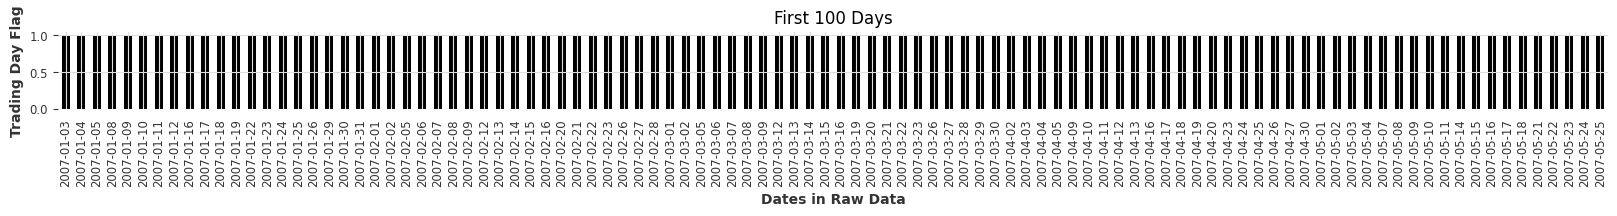

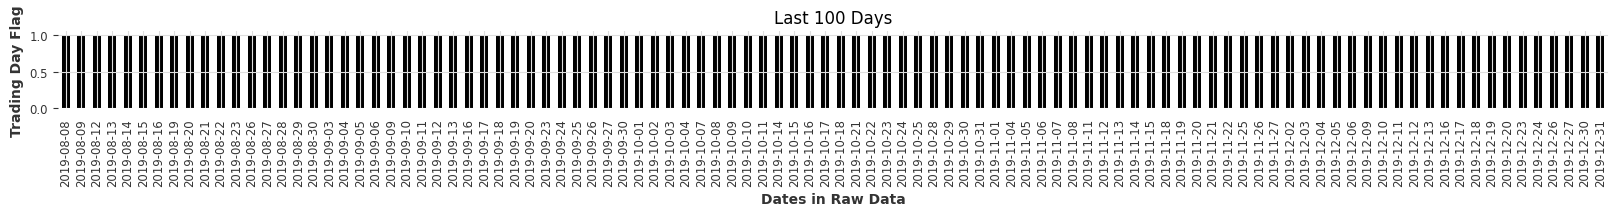

In [25]:
# Plot a bar plot with bars on the days which are in bar_tss:

y_values = [
    (ts in bar_tss) * 1.0
    for ts in daily_index
]
x_values = daily_index
df = pd.DataFrame(y_values, index=[str(ts).split(' ')[0] for ts in daily_index], columns=['Trading'])
# Bar plot:
df.iloc[:100, :].plot(
    kind='bar', 
    figsize=(20, 1), 
    xlabel='Dates in Raw Data', 
    ylabel='Trading Day Flag', 
    title='First 100 Days',
    legend=False,
)
_ = df.iloc[-100:, :].plot(
    kind='bar', 
    figsize=(20, 1), 
    xlabel='Dates in Raw Data', 
    ylabel='Trading Day Flag',
    title='Last 100 Days',
    legend=False,
)

In [26]:
# Downsample returns between Timestamps in bar_tss, by compounding returns between timestamps in bar_tss.
# Upcoming and observabel returns match, such that we can causally trade signals using the returns of the sime timestamp:
# For example the simplest possible backtest, placing $1 on each asset that lost in the period before will look like:
# pnl_df = (observable_bar_ret_cc_df < 0.0) * upcoming_bar_ret_cc_df

def compound_upcoming_bar_return_cc_df(
    ret_cc_df: pd.DataFrame, 
    bar_tss: List[pd.Timestamp]
) -> pd.DataFrame:
    """
    Compounds daily adjusted close to close returns for each Timestamp in bar_tss, 
    such that we can trade those at the 16:00 auction.
    
    Returns bars do not overlap, each covers a time period from 16:00 between bar_tss[i] and bar_tss[i+1].
    """
    # Returns end on the index date, need to align to the start date of the return
    ret_cc_df = ret_cc_df.shift(-1)   
    ret_cc_df = np.log(ret_cc_df + 1.0)  # convert to log returns
    bar_tss = bar_tss + [pd.Timestamp.max]
    log_bar_ret_df = pd.DataFrame(
        {
            # Indexing my Timestamp is inclusive, hence: .iloc[:-1, :]
            ts: ret_cc_df.loc[ts:bar_tss[i+1], :].iloc[:-1, :].sum()
            for i, ts in enumerate(bar_tss[:-1])
        }
    ).T
    return np.exp(log_bar_ret_df) - 1.0

def compound_observable_bar_return_cc_df(
    ret_cc_df: pd.DataFrame, 
    bar_tss: List[pd.Timestamp],
) -> pd.DataFrame:
    """
    Compounds daily adjusted close to close returns for each Timestamp in bar_tss, 
    such that we can observe those at 15:45 to trade the 16:00 auction.

    This means in practice using close prices only until previous close.
    
    Returns bars do not overlap, each covers a time period from 16:00 
    between bar_tss[i] and bar_tss[i+1].
    """
    
    ret_cc_df = np.log(ret_cc_df + 1.0)  # convert to log returns
    bar_tss = [pd.Timestamp.min] + bar_tss
    log_bar_ret_df = pd.DataFrame(
        {
            # Indexing my Timestamp is inclusive, hence: .iloc[:-1, :]
            ts: ret_cc_df.loc[bar_tss[i-1]:ts, :].iloc[:-1, :].sum()
            for i, ts in enumerate(bar_tss)
            if i > 0
        }
    ).T
    return np.exp(log_bar_ret_df) - 1.0

upcoming_bar_ret_cc_df = compound_upcoming_bar_return_cc_df(ret_cc_df, bar_tss)
observable_bar_ret_cc_df = compound_observable_bar_return_cc_df(ret_cc_df, bar_tss)

bar_universe_df = universe_df.loc[bar_tss, :]

In [27]:

# Establish the data used in the trading strategy at Timestamps in bat_tss, 
# available at the Timestamp in its index (observable_ prefix)

# Variables observable when trading on the bar_tss dates:
observable_ret_c1545_df = ret_c1545_df.loc[bar_tss, :]  # Can use the current 15:45 price
observable_bar_ret_cc1545_df = compound_ret_df(observable_bar_ret_cc_df, ret_c1545_df.loc[bar_tss, :])

observable_bar_signal_dfdict = {
    # Return from last daily close to today's 15:45 price:
    'day_ret_c1545': observable_ret_c1545_df,
    # Returns of period bar until previous close, compounded with returns until 15:45 from previous close:
    'bar_ret_cc1545': observable_bar_ret_cc1545_df,
}

# We can only use yesterday's close:
observable_ret_cc_df = ret_cc_df.shift(1)

for window_i in (1, 2, 5, 10):  # Conveniently sparse windows to reduce correlation
    observable_bar_signal_dfdict[f'day_ret_cc_{window_i:02d}'] = observable_ret_cc_df.rolling(window=window_i).sum().loc[bar_tss, :]
for window_i in (1, 2, 3, 6, 12):  # Conveniently sparse windows to reduce correlation
    observable_bar_signal_dfdict[f'bar_ret_cc_{window_i:02d}'] = observable_bar_ret_cc_df.rolling(window=window_i).sum().loc[bar_tss, :]


In [28]:
# Create a backtest loop, to make trading dacisions on each day in bar_tss

# for trade_ts in bar_tss:
#     print(f'Trading the close on {trade_ts}')

In [29]:
def signalbacktest_df(signal_df, upcoming_ret_df, enter_at_stdev=2.0):
    """A simple backtest, trading cross-sectional signals at a given standard deviation.

    Invests $0.5 both long and short, hence results can be interpreted as strategy returns.

    Args:
        signal_df: DataFrame with signals observable at the Timestamps in in its index.
        upcoming_ret_df: DataFrame with forward looking returns tradeable at the Timestamps in in its index.
        enter_at_stdev: Number of standard deviations to enter the trade both on long and short side.
    
    Returns:
        DataFrame with strategy returns.
    """
    is_long_df = signal_df.add(-(signal_df.mean(axis=1) - enter_at_stdev * signal_df.std(axis=1)), axis=0) > 0.0
    is_short_df = signal_df.add(-(signal_df.mean(axis=1) + enter_at_stdev * signal_df.std(axis=1)), axis=0) < 0.0

    signal_df = is_long_df.astype(int) - is_short_df.astype(int)
    # Demean cross-sectionally:
    signal_df = signal_df.add(-signal_df.mean(axis=1), axis=0)
    # Normalize cross-sectionally:
    signal_df = signal_df.div(signal_df.abs().sum(axis=1), axis=0)

    return signal_df * upcoming_ret_df

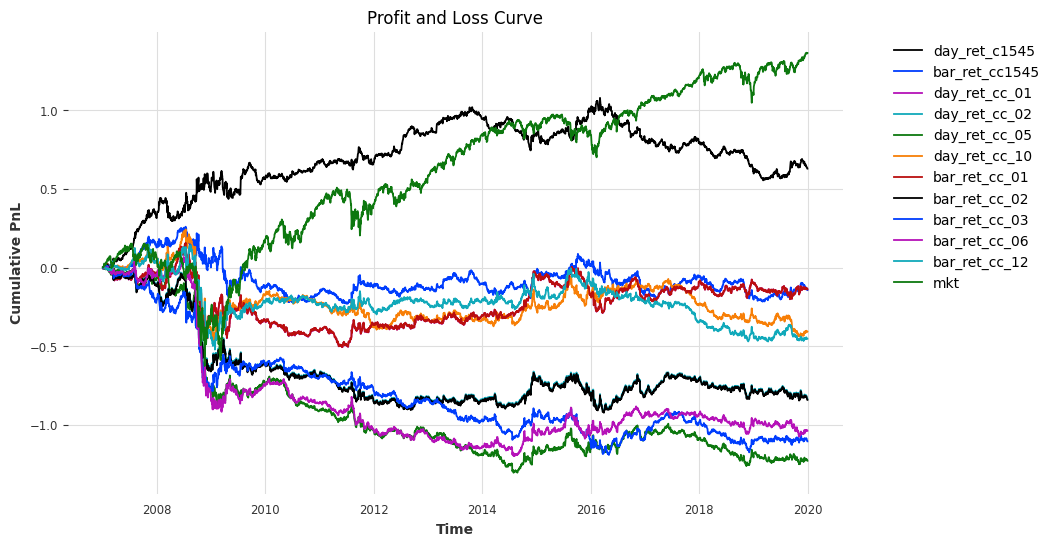

,day_ret_c1545,bar_ret_cc1545,day_ret_cc_01,day_ret_cc_02,day_ret_cc_05,day_ret_cc_10,bar_ret_cc_01,bar_ret_cc_02,bar_ret_cc_03,bar_ret_cc_06,bar_ret_cc_12,mkt
Cumulative PnL,0.628260,-0.143764,-0.138277,-0.835271,-1.228459,-0.407187,-0.138506,-0.841440,-1.104851,-1.037771,-0.452527,1.363477
Annual PnL,0.048639,-0.011130,-0.010705,-0.064666,-0.095107,-0.031524,-0.010723,-0.065144,-0.085537,-0.080344,-0.035034,0.105560
Average PnL,0.000192,-0.000044,-0.000042,-0.000255,-0.000376,-0.000124,-0.000042,-0.000257,-0.000338,-0.000317,-0.000138,0.000417
Maximum PnL,0.110898,0.077381,0.052114,0.062004,0.071426,0.064677,0.052114,0.062004,0.063747,0.068900,0.053599,0.123274
Minimum PnL,-0.084184,-0.079419,-0.075093,-0.080064,-0.093861,-0.103551,-0.075093,-0.080064,-0.083442,-0.101447,-0.106754,-0.106716
Annual Standard Deviation,0.151866,0.156684,0.147175,0.152730,0.156319,0.152807,0.147161,0.152807,0.152989,0.156841,0.153393,0.230233
Annual Sharpe Ratio,0.320279,-0.071035,-0.072739,-0.423401,-0.608411,-0.206300,-0.072866,-0.426314,-0.559104,-0.512262,-0.228395,0.458491
Sortino Ratio,0.417967,-0.085109,-0.089329,-0.504154,-0.718178,-0.249202,-0.089506,-0.507673,-0.670361,-0.591885,-0.277773,0.568226
Maximum Drawdown,-0.524027,-0.489266,-0.662222,-0.939524,-1.345738,-0.711616,-0.662237,-0.940135,-1.206316,-1.265782,-0.668331,-0.778526
Calmar Ratio,0.000367,-0.000090,-0.000064,-0.000272,-0.000279,-0.000175,-0.000064,-0.000274,-0.000280,-0.000251,-0.000207,0.000535


In [30]:
pnl_dict = {}

enter_at_stdev = 2.0

for key, signal_df in observable_bar_signal_dfdict.items():

    # signal_df = observable_bar_ret_cc_df
    # signal_ret_df = observable_dfdict['bar_ret_cc1545']
    # signal_ret_df = observable_ret_cc_df + ret_cc_df.loc[bar_tss, :]
    # Contains 1.0 and np.NaN values, this applies the universe:
    signal_df = signal_df * bar_universe_df
    trade_ret_df = signalbacktest_df(signal_df, upcoming_bar_ret_cc_df, enter_at_stdev=2.0)
    pnl_dict[key] = trade_ret_df.sum(axis=1)

signal_df = bar_universe_df.fillna(0.0)
signal_df = signal_df.div(signal_df.abs().sum(axis=1), axis=0)
pnl_dict['mkt'] = (signal_df * upcoming_bar_ret_cc_df).sum(axis=1)

strategy_pnl_df = pd.DataFrame(pnl_dict)

plot_pnl(strategy_pnl_df)
display(calculate_performance_df(strategy_pnl_df))